## Présentation du projet




Projet du cours d'Introduction au Machine Learning pour l'Image (IMLI)<br>
Promo : IMAGE 2025<br>
Etudiants :
  - PAUWELS Tom
  - MICHAUD Samuel
  - XU David



Répartition du travail:

- Préparation des données:
  à 3

- Modèles entrainés:
  - linearSVC: David X.

  - RandomForest: Tom P. et Samuel M.

  - KNN: Samuel M.

- Analyses des performances:
  à 3

- Fiabiliser l'évaluation:
  à 3

- Optimiser les modèles:
  à 3

- Fusion des données:

  - early fusion: Tom P.

  - late fusion: Samuel M. et David X.

  - intégration du LIDAR: Samuel M. et David X.

- Livrable:
David X. et Tom P. et Samuel M.

# Introduction

Nous disposons d'une image offrant une vue du ciel présentant différents éléments d'une ville tels que des arbres, de l'herbe, des routes, des bâtiments, etc.

Objectif du projet :

L'objectif est d'effectuer **la classification sémantique des pixels d'une scène**, c'est-à-dire d'assigner à chaque pixel la classe à laquelle il appartient.


###Importation des modules

In [272]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Classifier Linéaire
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import svm as svm

# Classifier Random Forest
from sklearn.ensemble import RandomForestClassifier

# Classifier K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Evaluation croisée
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold


### Téléchargement des données

#### La vérité terrain

In [273]:
%%bash
if [ -d "groundtruth" ]; then
    echo "Le dossier groundtruth existe déjà"
else
    mkdir -p "groundtruth"
    wget -q "https://www.lrde.epita.fr/~gtochon/IML/groundtruth.zip" -P "groundtruth"
    unzip -q "groundtruth/*.zip" -d "groundtruth"
    rm "groundtruth/"*.zip*
fi

Le dossier groundtruth existe déjà


#### Image hyperspectrale et image LIDAR

In [274]:
%%bash
if [ -d "data" ]; then
    echo "Le dossier data existe déjà"
else
    mkdir -p "data"
    wget -q "https://www.lrde.epita.fr/~gtochon/IML/data.zip" -P "data"
    unzip -q "data/*.zip" -d "data"
    rm "data/"*.zip*
fi

Le dossier data existe déjà


In [275]:
!find data groundtruth

data
data/lidar.npy
data/hyperspectral.npy
groundtruth
groundtruth/groundtruth.npy
groundtruth/groundtruth_info.npy
groundtruth/groundtruth.png


###Extraction des données

In [276]:
lidar = np.load("data/lidar.npy")
hsi_raw = np.load("data/hyperspectral.npy")
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

In [277]:
rgb_bands = [54,32,18]
hsi_rgb = hsi_raw[:,:,rgb_bands]
hsi_rgb = hsi_rgb/hsi_rgb.max() # normalisation des valeurs dans [0,1] pour l'affichage

# Don't mind me, I'm just here to pimp a little bit the RGB image
pmin,pmax = np.percentile(hsi_rgb,(1,95),axis=(0,1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:,:,i] = (hsi_rgb[:,:,i]-pmin[i])/(pmax[i]-pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped<0] = 0
hsi_rgb_pimped[hsi_rgb_pimped>1] = 1

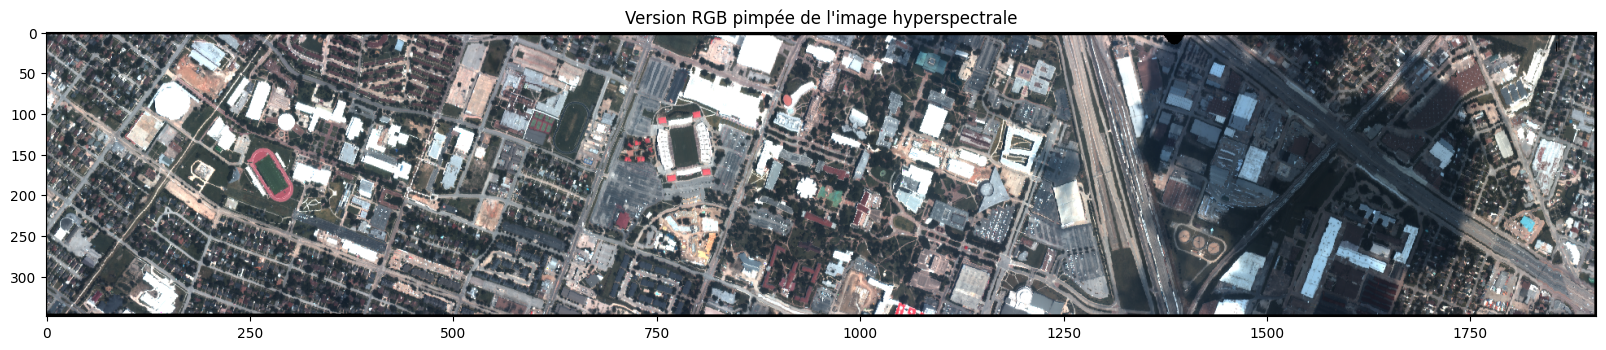

In [278]:
# la vue selon l'image hyperspectral réduit sur RGB
plt.figure(figsize=(20,8))
plt.title("Version RGB pimpée de l'image hyperspectrale")
plt.imshow(hsi_rgb_pimped)

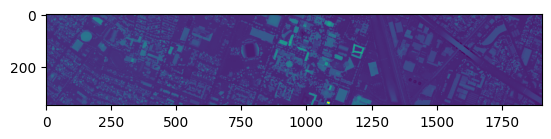

In [279]:
# la vue selon l'image LIDAR
plt.imshow(lidar)

In [280]:
# groundtruth_info nous permettra d'affecter une classe à une couleur
print(groundtruth_info)

[{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0])}
 {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0])}
 {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87])}
 {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0])}
 {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45])}
 {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255])}
 {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255])}
 {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216])}
 {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0])}
 {'class_name': 'highway', 'class_label': 10, 'class_color': array([139,   0,   0])}
 {'class_name': 'railway', 'class_label': 11, 'class_color': array([100, 100, 100])}
 {'class_name': 'parking_lot1', 'class_label': 12, 'class

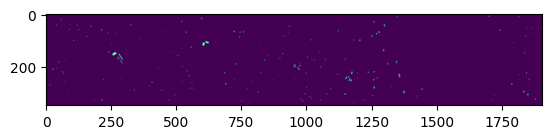

In [281]:
# la vérité terrain sur l'ensemble des canneaux
plt.imshow(groundtruth)

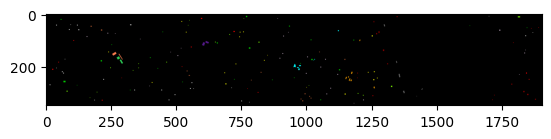

In [282]:
# la vérité terrain sur les canneaux RGB
plt.imshow(groundtruth_rgb)

###Création d'une seed

In [283]:
# Generation d'une seed
seed = np.random.seed(42)

### Création du dataset




In [284]:
# On crée un masque afin de "nettoyer" les pixels de classe 0 dans la vérité terrrain
mask = (groundtruth != 0)
#split the dataset into 2 part -> train set (80% of dataset) and test set (20% of it)
X_train, X_test, y_train, y_test = train_test_split(hsi_raw[mask], groundtruth[mask], test_size=0.2)

shape problem: une image hyperspectrale est nativement représentée comme un cube de données de dimensions $r \times c \times N$ où $r$ et $c$ correspondent au nombre de lignes et de colonnes dans l'image, et $N$ est le nombre de canaux, ce qui ne correspond pas au format attendu par la plupart des algorithmes de `scikit-image` ($N_{samples} \times N_{features}$, où $N_{samples}$ est le nombre d'échantillons et $N_{features}$ est le nombre de caractéristiques (la dimensionalité) de chaque échantillon).

In [285]:
# Pour pallier au shape problem : on reshape notre notre image pour predire sur cette dernière
print("hsi_raw shape: ", hsi_raw.shape)
hsi_raw_ = np.reshape(hsi_raw, (np.shape(hsi_raw)[0] * np.shape(hsi_raw)[1], np.shape(hsi_raw)[2]))
print("hsi_raw_ shape: ", hsi_raw_.shape)

hsi_raw shape:  (349, 1905, 144)
hsi_raw_ shape:  (664845, 144)


#Utils

Fonction données de l'énoncé :

In [286]:
def eval_performance_raw(predictions: np.array, targets: np.array):
    """Evalue la performance de l'algorithme de classification.

    Args:
        predictions (np.array): prédictions
        targets (np.array): valeurs attendues (vérité terrain)
    """
    # Check we have the right shape and dtype
    if predictions.shape != (349, 1905):
        raise ValueError("Les prédictions doivent être de shape (349, 1905)")
    if predictions.dtype != np.uint8:
        raise ValueError("Les prédictions doivent être de dtype uint8")
    if targets.shape != (349, 1905):
        raise ValueError("Les cibles doivent être de shape (349, 1905)")
    if targets.dtype != np.uint8:
        raise ValueError("Les cibles doivent être de dtype uint8")
    # Check predictions are in the correct domain
    if np.any(predictions > 15):
        raise ValueError("Les prédictions doivent être dans l'intervalle [0, 15]")
    if np.any(targets > 15):
        raise ValueError("Les cibles doivent être dans l'intervalle [0, 15]")
    # Compute the confusion matrix
    confusion_matrix = np.zeros((16, 16), dtype=np.int32)
    for i in range(16):
        for j in range(16):
            confusion_matrix[i, j] = np.sum((predictions == i) & (targets == j))
    # Compute the overall accuracy
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    # Compute the class-wise accuracy
    class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    # Accuracy ignoring the unclassified pixels in the ground truth
    mask = targets != 0
    accuracy_no_unclassified = np.sum(predictions[mask] == targets[mask]) / np.sum(mask)
    # Return the results
    return accuracy, class_accuracy, accuracy_no_unclassified, confusion_matrix

In [287]:
def load_eval_perf(filename: str, targets: np.array):
    """
    Charge les prédictions depuis un fichier NPZ et évalue la performance de l'algorithme de classification.

    Args:
        filename (str): nom du fichier NPZ contenant les prédictions
        targets (np.array): valeurs attendues (vérité terrain)
    """
    # Load the predictions
    predictions = np.load(filename)['predictions']
    # Evaluate the performance
    return eval_performance_raw(predictions, targets)

In [288]:
def export_predictions(predictions: np.array, filename: str):
    """
    Exporte les prédictions dans un fichier NPZ.
    :param predictions: np.array de shape (349, 1905) et de dtype uint8 contenant les prédictions
    :param filename: nom du fichier de sortie
    """
    # Check we have the right shape and dtype
    if predictions.shape != (349, 1905):
        raise ValueError("Les prédictions doivent être de shape (349, 1905)")
    if predictions.dtype != np.uint8:
        raise ValueError("Les prédictions doivent être de dtype uint8")
    # Check predictions are in the correct domain
    if np.any(predictions > 15):
        raise ValueError("Les prédictions doivent être dans l'intervalle [0, 15]")
    # Ensure the output file has the right extension
    if not filename.endswith('.npz'):
        filename += '.npz'
    # Save the predictions
    np.savez_compressed(filename, predictions=predictions)
    # Remind students to submit the file
    print(f"Prédictions exportées dans {filename}, n'oubliez pas d'envoyer votre fichier !")

Fonctions utiles pour plus tard

**affiche_palette** est une fonction qui permet d'afficher rapidement les différentes couleurs associée à chaque classe ainsi que leur signification.

In [289]:
def affiche_palette():
  groundtruth = np.load('groundtruth/groundtruth.npy')
  groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
  groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

  cls_rgb = []
  for ii in groundtruth_info:
      cls_rgb.append(ii['class_color'])
  cls_rgb = np.array(cls_rgb).reshape(15,-1,3)

  plt.figure(figsize=(3,3))
  plt.imshow(cls_rgb)
  plt.axis('off')
  for cls in range(15):
          plt.text(0.85,1.02*cls,'Classe %d : %s'%(cls+1,groundtruth_info[cls]['class_name']))
  plt.show()

**fast_prediction** est une fonction qui permet d'afficher ces statistiques liées a une prédiction:
* Graphe de fiabilité par classe
* Matrice de confusion
* Palette de couleur (*pour aider la lecture du graphe de fiabilité par classe*)

In [290]:
def fast_prediction (prediction):
  prediction_files = export_predictions(prediction, "prediction")
  print('\n')
  groundtruth = np.load('groundtruth/groundtruth.npy')

  accuracy, class_accuracy, accuracy_no_unclassified_micro, confusion_matrix = load_eval_perf("prediction.npz", groundtruth)
  print(f"\nFunction: \tMean accuracy (micro, no background): {accuracy_no_unclassified_micro:.2f}")
  accuracy_no_unclassified_macro = np.mean(class_accuracy[1:])
  print(f"Class: \t\tMean accuracy (macro, no background): {accuracy_no_unclassified_macro:.2f}\n")
  print("Accuracy:" ,accuracy)
  palette = sns.color_palette("Set1", 15)

  groundtruth_info = np.load('groundtruth/groundtruth_info.npy', allow_pickle=True)

  cls_rgb = []
  for ii in groundtruth_info:
      cls_rgb.append(ii['class_color'])
  cls_rgb = np.array(cls_rgb) / 255.0  # Normalisation des valeurs de couleur dans la plage 0-1

  # Affichage de la figure
  plt.figure(figsize=(15, 5))

  # Plot de l'accuracy
  plt.subplot(121)
  plt.title('Accuracy (shifted, without background)')
  bars = plt.bar(range(15), class_accuracy[1:])
  plt.xlim(-1, 15)

  # Coloration des barres en utilisant les couleurs récupérées
  for i in range(15):
      bars[i].set_color(cls_rgb[i])
  plt.gca().set_facecolor('black')

  # Plot de la matrice de confusion
  plt.subplot(122)
  plt.title('Confusion matrix (shifted, without background)')
  plt.imshow(confusion_matrix[1:, 1:], cmap='Blues')
  plt.show()
  print('\n')
  affiche_palette()

**find_color** permet de trouver la couleur associée au label qu'on donne en entrée

In [291]:
def find_color(class_label, groundtruth_info):
  for x in groundtruth_info:
    if x['class_label'] == class_label:
      return x['class_color']

**plot_prediction** renvoie la map, il ne reste plus qu'a l'afficher après cette fonction.

In [292]:
def plot_prediction(prediction):
  # return map(lambda x: groundtruth_info[(groundtruth_info['class_label'] == x)].class_color,prediction)
  img = np.zeros(shape=(prediction.shape[0], prediction.shape[1], 3))
  for i in range(len(prediction)):
    for j in range(len(prediction[0])):
      color = find_color(prediction[i][j], groundtruth_info)
      img[i][j] = color

  return img

**perform_cross_validate** effectue une validation croisée avec stratification. Nous séparons la dataset par défault en 5 folds.

In [293]:
def perform_cross_validate(model, X, y, cv=5, scoring='accuracy', fitted = True):
    if not fitted:
      model.fit(X, y)
    # Initialisation de la validation croisée avec stratification
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Exécution de la validation croisée avec cross_validate
    cv_results = cross_validate(model, X, y, cv=stratified_kfold, scoring=scoring, return_train_score=True)

    # cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    test_score = cv_results['test_score']
    train_score = cv_results['train_score']
    return test_score, train_score

**plot_accuracy_and_matrix** est une sous-fonction de **fast_prediction** sans l'exportation de la prédiction

In [294]:
def plot_accuracy_and_matrix(prediction):
  prediction = np.reshape(prediction,(349,1905))
  prediction = np.array(prediction)
  prediction = prediction.astype(np.uint8)
  fast_prediction(prediction)

# Entrainement de nos classifieurs

## Linear SVC

### Entrainement du classifieur linéaire

In [295]:
# Initialisation et entrainement du classifieur
classifier = svm.LinearSVC(random_state=seed)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [296]:
# On effectue la prédiction de notre classifieur sur l'image hsi entière
linear_prediction = classifier.predict(hsi_raw_)

### Annalyse de l'entrainement


Nous avons entraîné notre modèle linéaire de la manière la plus simple possible :

uniquement en utilisant l'image HSI, sans prendre en compte l'image LIDAR. Nous pouvons supposer que le nuage sera mal géré par le modèle.


Évaluons la fiabilité de notre modèle via une validation croisée avec stratification.

Après avoir étudié les nombreuses fonctions permettant d'évaluer notre modèle, la fonction cross_validate offre la plus grande flexibilité en termes de données sur notre modèle.


In [297]:
cv_test_score, cv_train_score = perform_cross_validate(classifier, hsi_raw[mask], groundtruth[mask])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [298]:
# chaque élément de la liste est l'accuracy test de notre modèle sur un fold de notre dataset
cv_test_score

array([0.78659612, 0.67548501, 0.74911661, 0.65724382, 0.64310954])

In [299]:
# chaque élément de la liste est l'accuracy train de notre modèle sur un fold de notre dataset
cv_train_score

array([0.81059603, 0.69448124, 0.7678729 , 0.66416593, 0.64827891])

In [300]:
print("le model est une accuracy de", "%.3f" % np.mean(cv_test_score), "sur le jeux de test")
print("le model est une accuracy de", "%.3f" % np.mean(cv_train_score), "sur le jeux d'entrainement")

le model est une accuracy de 0.702 sur le jeux de test
le model est une accuracy de 0.717 sur le jeux d'entrainement


D'après les résultats de la validation croisée, le modèle reste modestement fiable, malgré un grand nombre de pixels faussés par le nuage.

Il est à noter que le nombre de folds (parties du jeu de données) que nous avons partagées lors de la validation croisée est par défaut à 5. Cependant, plus ce nombre est élevé, plus la validation croisée est fiable.

Nous pouvons tout de même remarquer que d'un fold à un autre, l'accuracy reste dans le même ordre de grandeur.

### Analyse des performances

Prédictions exportées dans prediction.npz, n'oubliez pas d'envoyer votre fichier !



Function: 	Mean accuracy (micro, no background): 0.69
Class: 		Mean accuracy (macro, no background): 0.02

Accuracy: 0.0029420391219005934


<ipython-input-286-efad45868d77>:30: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


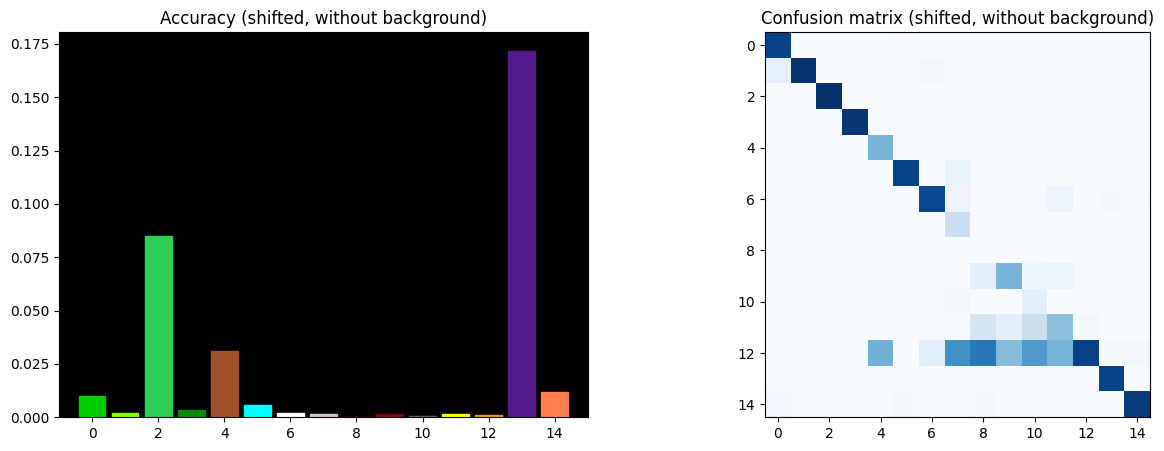

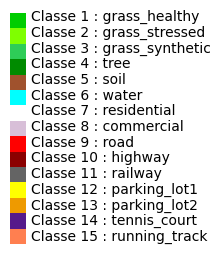

In [301]:
plot_accuracy_and_matrix(linear_prediction)

Cette manière est loin d'être la meilleure évaluation sachant que le groundtruth est composé en très grande partie de pixels de classe 0. Mais nous n'avons pas de vérité terrain plus grande que celle-ci.

Quelques remarques et quelques points d'incompréhension :

En considérant les informations qui nous sont données sur les performances de notre modèle :

* La matrice de confusion, qui est censée nous montrer le nombre de fois où chaque classe prédite correspond à chaque classe réelle.
* L'accuracy globale, qui nous montre le pourcentage d'échantillons correctement classés parmi tous les échantillons.
* L'accuracy par classe.
* L'accuracy en ignorant les pixels non classifiés dans la vérité terrain.



-- Tout d'abord, on remarque qu'il y a une erreur sur l'accuracy par classe due à une division par 0. Malgré cela, nous disposons du graphique de l'évaluation par classe et de l'accuracy dite macro, qui se base sur l'accuracy par classe.

-- Deuxièmement, la matrice de confusion est presque diagonale, ce que l'on recherche.

-- L'accuracy micro, qui ne prend pas en compte les pixels de classe 0, est celle qui va nous intéresser. Celle-ci est relativement satisfaisante : un bon pourcentage, nous avons pu prédire environ 70% de notre vérité terrain, ce qui est plutôt bon sachant que c'est avec cela que nous l'avons entraînée.

-- L'accuracy globale est bien évidemment basse, sachant que notre cible est le groundtruth et donc majoritairement composée de pixels de classe 0.

Pour améliorer un peu l'évaluation des autres pixels, nous pourrions effectuer une late fusion à l'aide d'autre modèle entrainé de la même manière.

In [302]:
# On créé une liste de (nb_model) model pour, par la suite, prendre la moyenne de leur prediction
linear_models = []
nb_model = 2
for k in range(nb_model):
  linear_model = svm.LinearSVC(random_state=seed)
  linear_model.fit(X_train, y_train)
  linear_models.append(linear_model)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [303]:
print("Vous allez évaluer la moyenne de", len(linear_models), "models")

Vous allez évaluer la moyenne de 2 models


In [304]:
def post_processing_vote(models, X_test):
    predictions = [model.predict(X_test) for model in models]
    print(predictions)
    fused_prediction = np.mean(predictions, axis=0)  # Fusion en prenant la moyenne
    return fused_prediction

In [305]:
fused_prediction = post_processing_vote(linear_models, hsi_raw_)

[array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8)]


Cette approche présente des aspects intéressants, mais il y a encore quelques points à considérer :

* Le nombre de modèles entraînés est en effet crucial, tout comme le nombre de folds. Un nombre trop faible peut affecter la fiabilité des résultats. L'utilisation de deux modèles par défaut pour réduire le temps d'exécution est compréhensible, mais il est important de noter que cela peut influencer la stabilité des résultats.

* Le choix de l'agrégat est également un aspect clé. Opter pour la moyenne semble raisonnable, mais sur un petit nombre de modèles, cela peut conduire à des résultats peu représentatifs. Par exemple, si un modèle prédit la classe 5 (sol) et un autre la classe 7 (résidence), la moyenne serait 6 (eau), ce qui est complètement inexact.

Il serait donc bénéfique d'explorer d'autres méthodes d'agrégation ou d'ajuster le nombre de modèles pour obtenir des résultats plus fiables et significatifs.

Testons pour une plus grande quantité de modèles.

In [306]:
a_million_model = []
nb_model = 10
for k in range(nb_model):
  linear_model = svm.LinearSVC(random_state=seed)
  linear_model.fit(X_train, y_train)
  a_million_model.append(linear_model)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [307]:
a_million_prediction = post_processing_vote(a_million_model, hsi_raw_)

[array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8), array([11, 11, 11, ..., 11, 11, 11], dtype=uint8)]


In [308]:
# Normalement better
def late_fusion_but_better(models, X_test):
    decision_scores = [model.decision_function(X_test) for model in models]
    # Convertir les scores de décision en probabilités en utilisant une sigmoid
    prob_predictions = [1 / (1 + np.exp(-decision)) for decision in decision_scores]
    mean_probs = np.mean(prob_predictions, axis=0)
    fused_prediction = np.argmax(mean_probs, axis=1)
    return fused_prediction

In [309]:
fused_prediction_but_better = late_fusion_but_better(linear_models, hsi_raw_)

Prédictions exportées dans prediction.npz, n'oubliez pas d'envoyer votre fichier !



Function: 	Mean accuracy (micro, no background): 0.62
Class: 		Mean accuracy (macro, no background): 0.02

Accuracy: 0.002660770555543021


<ipython-input-286-efad45868d77>:30: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


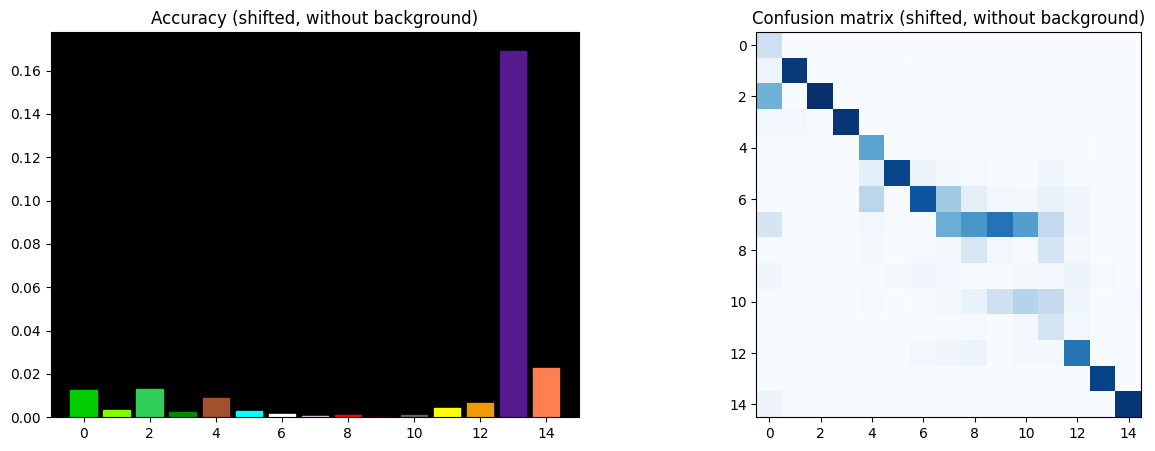

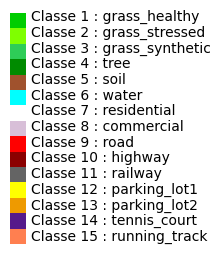

In [310]:
plot_accuracy_and_matrix(fused_prediction)

Prédictions exportées dans prediction.npz, n'oubliez pas d'envoyer votre fichier !



Function: 	Mean accuracy (micro, no background): 0.62
Class: 		Mean accuracy (macro, no background): 0.01

Accuracy: 0.0026532500056404124


<ipython-input-286-efad45868d77>:30: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


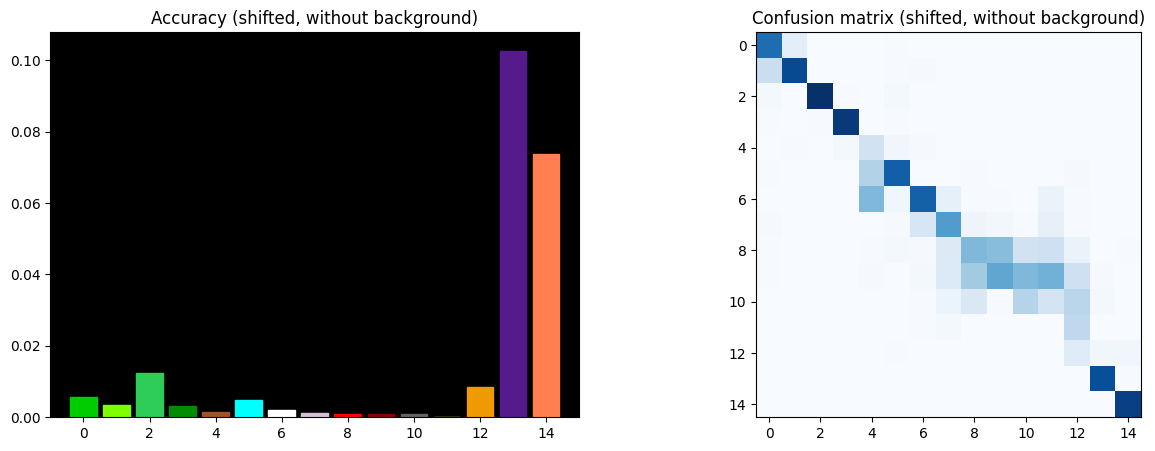

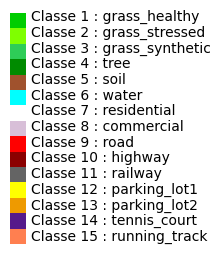

In [311]:
plot_accuracy_and_matrix(a_million_prediction)

On observe que les résultats sont meilleurs pour plus de modèles évalués

Prédictions exportées dans prediction.npz, n'oubliez pas d'envoyer votre fichier !



Function: 	Mean accuracy (micro, no background): 0.03
Class: 		Mean accuracy (macro, no background): nan

Accuracy: 0.017234092156818506


<ipython-input-286-efad45868d77>:30: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


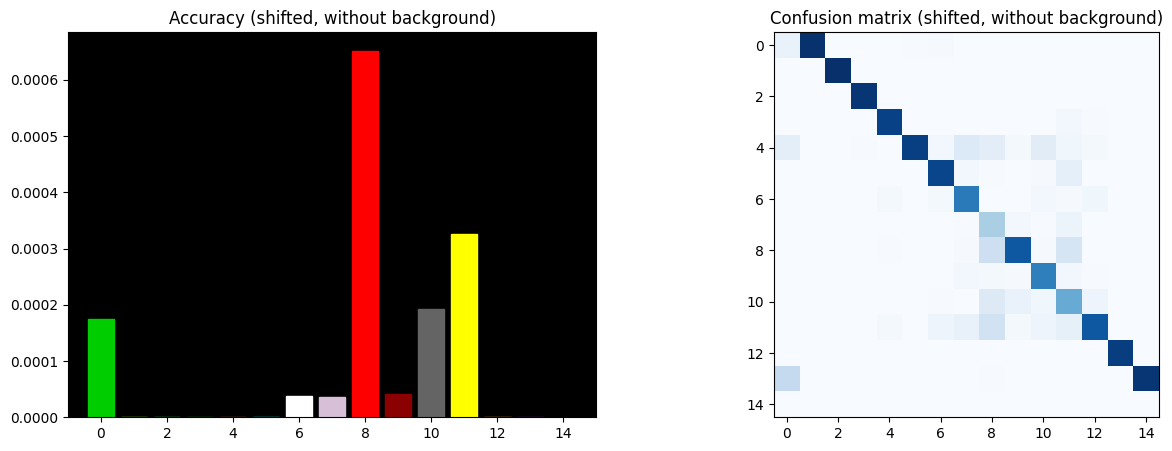

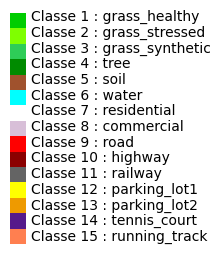

In [312]:
plot_accuracy_and_matrix(fused_prediction_but_better)

Ici les résultats sont nettement meilleurs, néanmoins la diagonale de la matrice de confusion est décalée de 1 vers le haut.

## Random Forest


###Entrainement du classifieur Random Forest

Evaluation du model en fonction de l'hyperparametre du nombre d'estimateur n_estimators.


In [313]:
n_estimators = 0

####Random Forest avec 10 estimateurs

On initialise le model de Classifieur Random Forest avec tout d'abord un nombre arbitraire de n_estimators = 10.


In [314]:
n_estimators = 10
# Initialisation et entraînement du modèle de classification (Random Forest)
clf_RFC_10 = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)

clf_RFC_10.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

####Random Forest avec 30 estimateurs


In [315]:
n_estimators = 30
clf_RFC_30 = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)

clf_RFC_30.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30)

####Random Forest avec 100 estimateurs


In [316]:
n_estimators = 100
clf_RFC_100 = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)

clf_RFC_100.fit(X_train, y_train)

RandomForestClassifier()

####Random Forest avec 1000 estimateurs

In [317]:
n_estimators = 1000
clf_RFC_1000 = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)

clf_RFC_1000.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

### Analyse de l'entrainement


In [ ]:
RFC_models = [clf_RFC_10, clf_RFC_30, clf_RFC_100, clf_RFC_1000]
RFC_scores = []

for model in RFC_models:
  cv_test_score, cv_train_score = perform_cross_validate(model, hsi_raw[mask], groundtruth[mask])
  RFC_scores.append({'cv_test_score' : cv_test_score, 'cv_train_score': cv_train_score})
test_means = np.mean([arr['cv_test_score'] for arr in RFC_scores], axis=1)
train_means = np.mean([arr['cv_train_score'] for arr in RFC_scores], axis=1)
print(test_means)
print(train_means)

In [ ]:
test_means = [np.mean(arr['cv_test_score']) for arr in RFC_scores]
train_means = [np.mean(arr['cv_train_score']) for arr in RFC_scores]

print("Moyenne de l'accuracy sur chaque ensemble de test :", np.mean(test_means))
print("Moyenne de l'accuracy sur chaque ensemble d'entraînement :", np.mean(train_means))

In [ ]:
test_means = ["%.3f" % score for score in test_means]
train_means = ["%.3f" % score for score in train_means]

data = {
    "test": test_means,
    "train": train_means
}

index = ["n_estimators=10", "n_estimators=30", "n_estimators=100", "n_estimators=1000"]
df = pd.DataFrame(data, index=index)
df

###Analyse des performences (Random Forest)

Après avoir tester pour plusieurs valeurs de n_estimators 10, 30, 100, 1000, on peut en conclure qu'aller au dela de 100 éstimateurs augmente

In [ ]:
# Prédiction sur l'ensemble de test
predictions_RFC_10 = clf_RFC_10.predict(hsi_raw_)

# Reshape des prédictions
predictions_RFC_10 = np.reshape(predictions_RFC_10,(349,1905))

# Affichage des prédictions
fast_prediction(predictions_RFC_10)

# Affichage de la prediction sous forme de carte
plt.imshow(plot_prediction(predictions_RFC_10))

In [ ]:
# Prédiction sur l'ensemble de test
predictions_RFC_30 = clf_RFC_30.predict(hsi_raw_)

# Reshape des prédictions
predictions_RFC_30 = np.reshape(predictions_RFC_30,(349,1905))

# Affichage des prédictions
fast_prediction(predictions_RFC_30)

# Affichage de la prediction sous forme de carte
plt.imshow(plot_prediction(predictions_RFC_30))

In [ ]:
# Prédiction sur l'ensemble de test
predictions_RFC_100 = clf_RFC_100.predict(hsi_raw_)

# Reshape des prédictions
predictions_RFC_100 = np.reshape(predictions_RFC_100,(349,1905))

# Affichage des prédictions
fast_prediction(predictions_RFC_100)

# Affichage de la prediction sous forme de carte
plt.imshow(plot_prediction(predictions_RFC_100))

Prédictions exportées dans prediction.npz, n'oubliez pas d'envoyer votre fichier !



Function: 	Mean accuracy (micro, no background): 0.98
Class: 		Mean accuracy (macro, no background): 0.01

Accuracy: 0.004157359986162189


<ipython-input-180-efad45868d77>:30: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


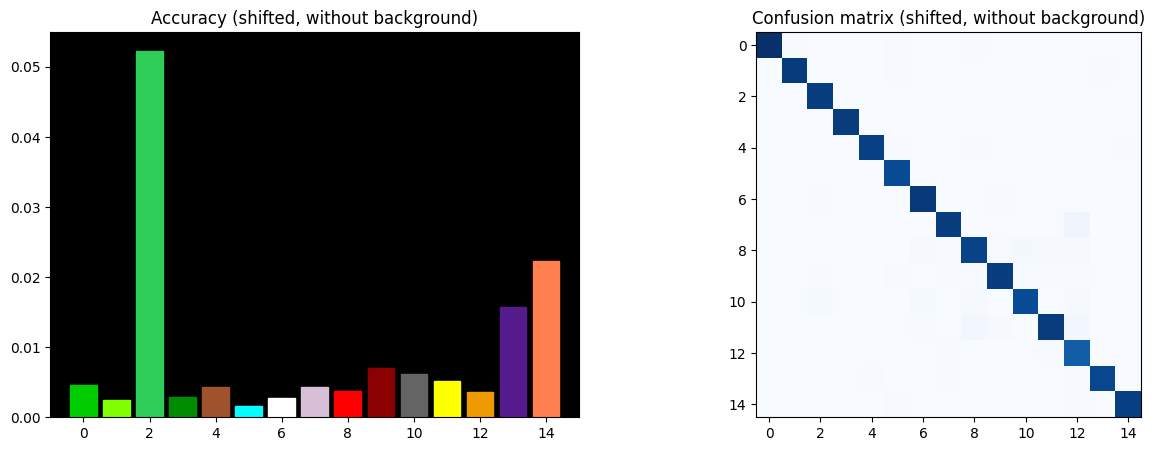

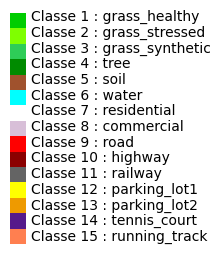

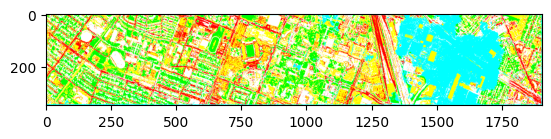

In [271]:
# Prédiction sur l'ensemble de test
predictions_RFC_1000 = clf_RFC_1000.predict(hsi_raw_)

# Reshape des prédictions
predictions_RFC_1000 = np.reshape(predictions_RFC_1000,(349,1905))

# Affichage des prédictions
fast_prediction(predictions_RFC_1000)

# Affichage de la prediction sous forme de carte
plt.imshow(plot_prediction(predictions_RFC_1000))

On observe que plus le nombre de n_estimators est grand, plus on est précis. Par ailleurs, on voit qu'à partir de n_estimators=100 on converge, donc on n'a pas besoin d'augmenter n_estimators au dela de 100.

## K-Nearest Neighbors

### Entrainement du classifieur K-Nearest Neighbors (KNN)

---



#### KNN avec k=1

In [ ]:
clf_KNN_1 = KNeighborsClassifier(n_neighbors=1)
clf_KNN_1.fit(X_train, y_train)

#### KNN avec k=5

On test tout d'abord avec un nombre arbitraire de voisins : <u>k = 5</u>

In [ ]:
clf_KNN_5 = KNeighborsClassifier(n_neighbors=5)
clf_KNN_5.fit(X_train, y_train)

On teste en changeant le nombre de voisins : <u>k = 10</u>

#### KNN avec k=10

In [ ]:
clf_KNN_10 = KNeighborsClassifier(n_neighbors=10)
clf_KNN_10.fit(X_train, y_train)

### Analyse des entrainements (KNN)

### Analyse des performances (KNN)

On fait une fonction pour effectuer l'analyse plus facilement

In [ ]:
def KNN_analyse (clf_KNN):
  predictions_KNN = clf_KNN.predict(hsi_raw_)

  predictions_KNN = np.reshape(predictions_KNN,(349,1905))

  print("Shape de la prediction :", predictions_KNN.shape)

  # Affichage des prédictions
  fast_prediction(predictions_KNN)

  print('\n')

  plt.imshow(plot_prediction(predictions_KNN), cmap='jet')

**Analyse pour <u>K = 1</u>**

In [ ]:
KNN_analyse(clf_KNN_1)

**Analyse pour <u>K = 5</u>**

In [ ]:
KNN_analyse(clf_KNN_5)

**Analyse pour <u>K = 10</u>**

In [ ]:
KNN_analyse(clf_KNN_10)

In [ ]:
KNN_models = [clf_KNN_1, clf_KNN_5, clf_KNN_10]
KNN_scores = []

for model in KNN_models:
  cv_test_score, cv_train_score = perform_cross_validate(model, hsi_raw[mask], groundtruth[mask])
  KNN_scores.append({'cv_test_score' : cv_test_score, 'cv_train_score': cv_train_score})

In [ ]:
test_means = np.mean([arr['cv_test_score'] for arr in KNN_scores], axis=1)
train_means = np.mean([arr['cv_train_score'] for arr in KNN_scores], axis=1)

test_means = ["%.3f" % score for score in test_means]
train_means = ["%.3f" % score for score in train_means]

In [ ]:
data = {
    "test": test_means,
    "train": train_means
}

index = ["k=1", "k=5", "k=10"]
df = pd.DataFrame(data, index=index)

In [ ]:
df

On constate que le K-Nearest Neighbors est le plus performant pour k = 1 en plus d'être le plus fiable.

On précise que la première valeur de k testée est 5.

Dans l'optique d'optimiser le modèle on a ensuite augmenté la valeur de k pour se rendre compte qu'il fallait la diminuer.

## Fusion de caractéristiques

Le modèle utilisé pour faire l'étude de fusion de caratéristiques est le KNN avec k=1.

###Early fusion

In [ ]:
# Reshape des donnees du Lidar pour les rendre compatibles avec l'hyperspectral
lidar_ = lidar.reshape(lidar.shape[0], lidar.shape[1], 1)

In [ ]:
X = np.concatenate((hsi_raw, lidar_), axis=2)

In [ ]:
#Normalisation des donnees pour le HSI et Lidar : z = (x - u) / s
scaler = StandardScaler()
X_ = np.reshape(X, (np.shape(X)[0] * np.shape(X)[1], np.shape(X)[2]))

X_combined_normalized = scaler.fit_transform(X_)

In [ ]:
X_combined_normalized = np.reshape(X_combined_normalized, (X.shape[0], X.shape[1],X.shape[2]))

# Séparation des données en ensemble d'entraînement et de test
X_combined_train, X_combined_test, y_combined_train, y_combined_test = train_test_split(X_combined_normalized[mask], groundtruth[mask], test_size=0.2, random_state=seed)

Initialisation et entrainement du classifer

In [ ]:
clf_KNN_1_early = KNeighborsClassifier(n_neighbors=1)
clf_KNN_1_early.fit(X_combined_train, y_combined_train)

In [ ]:
X_combined_reshaped = np.reshape(X_combined_normalized, (np.shape(X)[0] * np.shape(X)[1], np.shape(X)[2]))

predictions_combined = clf_KNN_1_early.predict(X_combined_reshaped)

In [ ]:
predictions_combined = np.reshape(predictions_combined,(349,1905))

fast_prediction(predictions_combined)

plt.imshow(plot_prediction(predictions_combined))

Essayons une nouvelle méthode de normalisation des données pour une early fusion: prenons une max-min normalization.

Sachant que la fonction fit_transform (de sikitlearn) utilise une z-score normalization.

In [ ]:
#Normalisation des donnees pour le HSI et Lidar : x = (x - min) / (max - min)

# Normalisation des données pour le HSI
hsi_raw_normalisee = (hsi_raw - np.min(hsi_raw, axis=(0, 1), keepdims=True)) / \
                     (np.max(hsi_raw, axis=(0, 1), keepdims=True) - np.min(hsi_raw, axis=(0, 1), keepdims=True))

# Normalisation des données pour le LiDAR
lidar_normalisee = (lidar_ - np.min(lidar_, axis=(0, 1), keepdims=True)) / \
                   (np.max(lidar_, axis=(0, 1), keepdims=True) - np.min(lidar_, axis=(0, 1), keepdims=True))


X_concat = np.concatenate((hsi_raw_normalisee, lidar_normalisee), axis=2)

Séparation des données en ensemble d'entraînement et de test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_concat[mask], groundtruth[mask], test_size=0.2, random_state=seed)

Initialisation et entrainement du classifieur

In [ ]:
clf_KNN_1_early_max_min = KNeighborsClassifier(n_neighbors=1)
clf_KNN_1_early_max_min.fit(X_train, y_train)

In [ ]:
X_concat_reshaped = np.reshape(X_concat, (np.shape(X)[0] * np.shape(X)[1], np.shape(X)[2]))

predictions = clf_KNN_1_early_max_min.predict(X_concat_reshaped)

In [ ]:
predictions = np.reshape(predictions,(349,1905))

fast_prediction(predictions)

plt.imshow(plot_prediction(predictions))

###Late fusion

Séparation des données en ensemble d'entraînement et de test

In [ ]:
X_train_hsi, X_test_hsi, y_train_hsi, y_test_hsi = train_test_split(hsi_raw[mask], groundtruth[mask], test_size=0.2, random_state=seed)
X_train_lidar, X_test_lidar, y_train_lidar, y_test_lidar = train_test_split(lidar[mask], groundtruth[mask], test_size=0.2, random_state=seed)


On initialise nos classifiers

In [ ]:
clf_hsi = KNeighborsClassifier(n_neighbors=1)
clf_lidar = KNeighborsClassifier(n_neighbors=1)

Entrainement de nos classifiers

In [ ]:
clf_hsi.fit(X_train_hsi, y_train_hsi)
X_train_lidar = np.reshape(X_train_lidar, (X_train_lidar.shape[0], 1))
clf_lidar.fit(X_train_lidar, y_train_lidar)

On effectue les prédictions

In [ ]:
# Prediction HSI
# hsi_raw_ : hsi_raw à la bonne shape
hsi_raw_ = np.reshape(hsi_raw, (np.shape(hsi_raw)[0] * np.shape(hsi_raw)[1], np.shape(hsi_raw)[2]))
predictions_hsi = clf_hsi.predict(hsi_raw_)

In [ ]:
predictions_hsi = np.reshape(predictions_hsi,(349,1905))

In [ ]:
# Prediction LIDAR
# lidar_ : lidar à la bonne shape
lidar_ = np.reshape(lidar, (np.shape(lidar)[0] * np.shape(lidar)[1], 1))

predictions_lidar = clf_lidar.predict(lidar_)

In [ ]:
predictions_lidar = np.reshape(predictions_lidar,(349,1905))

En analysant les deux predictions indépendemment, on vérifie la cohérence des résultats afin d'effectuer un post-processing qui consiste en une correction/fusion manuelle sur les résultats afin d'avoir une prédiction optimale.

On remarque sur la zone du nuage de l'image HSI, on prédit majoritairement de l'eau (classe 6) et de parking lot 1 (classe 12).
Pour effectuer la correction manuelle, on prend d'abord la prédiction du HSI sur laquelle nous remplaçons ces valeures de prédictions par celles du LIDAR.

In [ ]:
late_fusion_depending_on_zone_predictions = predictions_hsi.copy()

# Si la classe predite par l'hyperspectral est la classe numero 6 dans la zone du nuage prendre la prediction du lidar
debut_du_nuage = 1275
water_class = 6
parking_lot1_class = 12
for i in range(349):
    for j in range(1905):
        if late_fusion_depending_on_zone_predictions[i][j] == water_class \
        or late_fusion_depending_on_zone_predictions[i][j] == parking_lot1_class \
        and j > debut_du_nuage:
            late_fusion_depending_on_zone_predictions[i][j] = predictions_lidar[i][j]

fast_prediction(late_fusion_depending_on_zone_predictions)

plt.imshow(plot_prediction(late_fusion_depending_on_zone_predictions))


Effectivement, si nous cherchons à éviter les inconvénients de l'agrégat moyen, nous pourrions envisager d'autres approches telles que l'utilisation de l'agrégat maximum ou minimum.

Il est important de noter que chaque approche a ses propres avantages et inconvénients, et le choix dépendra souvent du contexte spécifique du problème et des préférences de l'utilisateur. Parfois, une combinaison d'agrégats ou l'utilisation d'une méthode plus sophistiquée comme le vote pondéré peut être envisagée pour obtenir des résultats plus robustes.

Dans cette version, nous utilisons decision_function pour obtenir les scores de décision pour chaque classe pour chaque modèle. Ensuite, nous utilisons une sigmoide pour transformer ces scores en probabilités.

# Rendu

## Prédiction finale


In [ ]:
!rm -f prediction.npz

In [ ]:
export_predictions(late_fusion_depending_on_zone_predictions, "final_prediction")

In [ ]:
!ls

Veuillez trouver notre prédiction optimale sous le nom de : "**final_prediction.npz**"